In [1]:
import torch
import json
from keras.preprocessing.sequence import pad_sequences
import pickle
import pandas as pd
from keras.preprocessing.text import Tokenizer
import torch.nn as nn
import numpy as np, pickle, time, argparse
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support

import tensorflow as tf
import contractions
from sklearn.preprocessing import LabelBinarizer
import time
import tensorflow.keras as k
import os
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [2]:
"deal with contracted texts"
def expand_text(text):
    expanded_words = []
    text = text.encode('utf-8').decode('cp1252').replace("Â’", "'")
    #text = text.replace("’", "'")
    for word in text.split():
      # using contractions.fix to expand the shotened words
      expanded_words.append(contractions.fix(word))   

    expanded_text = ' '.join(expanded_words)
    return expanded_text



"clean dataset"
def preprocess_text(x):
    for punct in '"!&?.,}-/<>#$%\()*+:;=?@[\\]^_`|\~':
        x = x.replace(punct, ' ')
    x = ' '.join(x.split())
    x = x.lower()
    
    return x


def create_utterances(filename, split):
    sentences, emotion_labels, speakers, conv_id, = [], [], [], []
    
    lengths = []
    with open(filename, 'r', encoding='latin1') as f:
        a = json.load(f)
        for c_id, line in enumerate(a):
            for item in line:
                sentences.append(item['utterance'])
                emotion_labels.append(item['emotion'])
                conv_id.append(split[:2] + '_c' + str(c_id))
                speakers.append(item['speaker'])
            
            # u_id += 1
                
    data = pd.DataFrame(sentences, columns=['sentence'])
    data['sentence'] = data['sentence'].apply(lambda x: expand_text(x))
    data['sentence'] = data['sentence'].apply(lambda x: preprocess_text(x))

    data['emotion_label'] = emotion_labels
    data['speaker'] = speakers
    data['conv_id'] = conv_id

    
    return data


In [3]:
"create embedding"
def load_pretrained_glove():
    print("Loading GloVe model, this can take some time...")
    glv_vector = {}
    f = open('glove.840B.300d.txt', encoding='utf-8')

    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float')
            glv_vector[word] = coefs
        except ValueError:
            continue
    f.close()
    print("Completed loading pretrained GloVe model.")
    return glv_vector

def encode_labels(encoder, l):
    return encoder[l]


if __name__ == '__main__':

    train_data = create_utterances('Friends/friends_train.json', 'train')
    valid_data = create_utterances('Friends/friends_dev.json', 'valid')
    test_data = create_utterances('Friends/friends_test.json', 'test')
    
    ## encode the emotion and dialog act labels ##
    all_emotion_labels =  set(train_data['emotion_label'])
    emotion_label_encoder, emotion_label_decoder = {}, {}


    for i, label in enumerate(all_emotion_labels):
        emotion_label_encoder[label] = i
        emotion_label_decoder[i] = label


    pickle.dump(emotion_label_encoder, open('emotion_label_encoder.pkl', 'wb'))
    pickle.dump(emotion_label_decoder, open('emotion_label_decoder.pkl', 'wb'))

    train_data['encoded_emotion_label'] = train_data['emotion_label'].map(lambda x: encode_labels(emotion_label_encoder, x))
    test_data['encoded_emotion_label'] = test_data['emotion_label'].map(lambda x: encode_labels(emotion_label_encoder, x))
    valid_data['encoded_emotion_label'] = valid_data['emotion_label'].map(lambda x: encode_labels(emotion_label_encoder, x))
    
    
    ## tokenize all sentences ##
    all_text = list(train_data['sentence'])
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_text)
    pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

    ## convert the sentences into sequences ##
    train_sequence = tokenizer.texts_to_sequences(list(train_data['sentence']))
    valid_sequence = tokenizer.texts_to_sequences(list(valid_data['sentence']))
    test_sequence = tokenizer.texts_to_sequences(list(test_data['sentence']))
    
    train_data['sentence_length'] = [len(item) for item in train_sequence]
    valid_data['sentence_length'] = [len(item) for item in valid_sequence]
    test_data['sentence_length'] = [len(item) for item in test_sequence]
    
    max_num_tokens = 250

    train_sequence = pad_sequences(train_sequence, maxlen=max_num_tokens, padding='post')
    valid_sequence = pad_sequences(valid_sequence, maxlen=max_num_tokens, padding='post')
    test_sequence = pad_sequences(test_sequence, maxlen=max_num_tokens, padding='post')

    train_data['sequence'] = list(train_sequence)
    valid_data['sequence'] = list(valid_sequence)
    test_data['sequence'] = list(test_sequence)
    
   
    
    ## save pretrained embedding matrix ##
    glv_vector = load_pretrained_glove()
    word_vector_length = len(glv_vector['the'])
    word_index = tokenizer.word_index
    inv_word_index = {v: k for k, v in word_index.items()}
    num_unique_words = len(word_index)
    glv_embedding_matrix = np.zeros((num_unique_words+1, word_vector_length))

    for j in range(1, num_unique_words+1):
        try:
            glv_embedding_matrix[j] = glv_vector[inv_word_index[j]]
        except KeyError:
            glv_embedding_matrix[j] = np.random.randn(word_vector_length)/200

    np.ndarray.dump(glv_embedding_matrix, open('glv_embedding_matrix', 'wb'))
    print ('Done. Completed preprocessing.')

Loading GloVe model, this can take some time...
Completed loading pretrained GloVe model.
Done. Completed preprocessing.


In [4]:
train_data['emotion_true'] = pd.get_dummies(train_data['encoded_emotion_label']).values.tolist()


In [5]:
train_data

,sentence,emotion_label,speaker,conv_id,encoded_emotion_label,sentence_length,sequence,emotion_true
0,also i was the point person on my company's tr...,neutral,Chandler,tr_c0,7,18,"[371, 1, 31, 5, 695, 401, 33, 26, 2758, 2759, ...","[0, 0, 0, 0, 0, 0, 0, 1]"
1,you must have had your hands full,neutral,The Interviewer,tr_c0,7,7,"[2, 311, 17, 98, 44, 643, 760, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1]"
2,that i did that i did,neutral,Chandler,tr_c0,7,6,"[9, 1, 48, 9, 1, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 1]"
3,so let us talk a little bit about your duties,neutral,The Interviewer,tr_c0,7,10,"[23, 84, 79, 175, 7, 100, 402, 54, 44, 1470, 0...","[0, 0, 0, 0, 0, 0, 0, 1]"
4,my duties all right,surprise,Chandler,tr_c0,4,4,"[26, 1470, 34, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
10556,you or me,neutral,Chandler,tr_c719,7,3,"[2, 112, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1]"
10557,i got it uh joey women do not have adam's apples,non-neutral,Ross,tr_c719,3,11,"[1, 57, 6, 51, 81, 316, 12, 8, 17, 2757, 5888,...","[0, 0, 0, 1, 0, 0, 0, 0]"
10558,you guys are messing with me right,surprise,Joey,tr_c719,4,7,"[2, 87, 13, 2747, 37, 20, 36, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 1, 0, 0, 0]"
10559,yeah,neutral,All,tr_c719,7,1,"[24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 1]"


In [286]:
train_data['sequence'] = np.array(train_data['sequence'])

In [287]:
dialogue_train_data = train_data.groupby("conv_id").agg(list)


In [288]:
dialogue_train_data

,sentence,emotion_label,speaker,encoded_emotion_label,sentence_length,sequence,emotion_true
conv_id,,,,,,,
tr_c0,[also i was the point person on my company's t...,"[neutral, neutral, neutral, neutral, surprise,...","[Chandler, The Interviewer, Chandler, The Inte...","[7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 5, 7, 4, 7, 4, ...","[18, 7, 6, 10, 4, 16, 2, 18, 3, 5, 7, 28, 1, 7...","[[371, 1, 31, 5, 695, 401, 33, 26, 2758, 2759,...","[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, ..."
tr_c1,"[hey mon, hey hey hey you want to hear somethi...","[neutral, neutral, joy, sadness, surprise, neu...","[Chandler, Monica, Chandler, Monica, Chandler,...","[7, 7, 6, 2, 4, 7, 3, 2, 7, 7, 6, 7, 3, 4, 4, ...","[2, 10, 3, 8, 2, 12, 10, 2, 5, 6, 2, 5, 4, 8, ...","[[28, 509, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, ..."
tr_c10,"[go go go, oh yeah now everybody wants to be u...","[joy, joy, non-neutral, surprise, neutral, neu...","[Ross, Rachel, Phoebe, Monica, Phoebe, Ross]","[6, 6, 3, 4, 7, 7]","[3, 10, 1, 6, 9, 10]","[[43, 43, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, ..."
tr_c100,[ooh oh no i have to go i have a massage appoi...,"[non-neutral, neutral, neutral, joy, non-neutr...","[Phoebe, Eric, Phoebe, Eric, Mona, Ross, Dr. G...","[3, 7, 7, 6, 3, 7, 0, 2]","[12, 13, 13, 7, 10, 6, 19, 10]","[[219, 11, 16, 1, 17, 4, 43, 1, 17, 7, 1328, 1...","[[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ..."
tr_c101,"[okay so we will just stay married, yes exactl...","[joy, joy, joy, non-neutral, fear, non-neutral...","[Rachel, Ross, Rachel, Ross, Rachel, Ross, Rac...","[6, 6, 6, 3, 5, 3, 4, 7, 3, 6, 7, 2, 7, 7, 3, ...","[7, 2, 9, 19, 15, 12, 10, 9, 1, 27, 2, 5, 3, 2...","[[22, 23, 18, 41, 25, 254, 186, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
tr_c95,"[hey joey you wanted to talk to me, i do not k...","[neutral, neutral, neutral, neutral, surprise,...","[Tag, Joey, Tag, Joey, Tag, Joey]","[7, 7, 7, 7, 4, 6]","[8, 11, 6, 13, 1, 3]","[[28, 81, 2, 198, 4, 175, 4, 20, 0, 0, 0, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, ..."
tr_c96,[oh danielle i was not expecting the machine g...,"[surprise, neutral, non-neutral, non-neutral, ...","[Chandler, Monica, Chandler, Ross, Chandler, C...","[4, 7, 3, 3, 5, 5, 3, 4, 0, 1, 1, 1, 3, 0, 3, ...","[21, 2, 5, 5, 2, 12, 21, 12, 9, 6, 9, 9, 4, 7,...","[[11, 3176, 1, 31, 8, 1150, 5, 503, 136, 20, 7...","[[0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, ..."
tr_c97,"[y'know they say a watched pot never beeps, it...","[neutral, non-neutral, neutral, anger, neutral...","[Monica, Phoebe, Monica, Phoebe, Monica, Phoeb...","[7, 3, 7, 0, 7, 7, 7, 7, 7, 2, 2, 2, 2]","[8, 20, 12, 7, 6, 1, 6, 5, 2, 2, 2, 19, 26]","[[53, 63, 101, 7, 3180, 3181, 128, 2103, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, ..."


In [289]:
class MyLabelBinarizer:

    def __init__(self):
        self.lb = LabelBinarizer()

    def fit(self, X):
        # Convert X to array
        X = np.array(X)
        # Fit X using the LabelBinarizer object
        self.lb.fit(X)
        # Save the classes
        self.classes_ = self.lb.classes_

    def fit_transform(self, X):
        # Convert X to array
        X = np.array(X)
        # Fit + transform X using the LabelBinarizer object
        Xlb = self.lb.fit_transform(X)
        # Save the classes
        self.classes_ = self.lb.classes_
        if len(self.classes_) == 2:
            Xlb = np.hstack((Xlb, 1 - Xlb))
        return Xlb

    def transform(self, X):
        # Convert X to array
        X = np.array(X)
        # Transform X using the LabelBinarizer object
        Xlb = self.lb.transform(X)
        if len(self.classes_) == 2:
            Xlb = np.hstack((Xlb, 1 - Xlb))
        return Xlb

    def inverse_transform(self, Xlb):
        # Convert Xlb to array
        Xlb = np.array(Xlb)
        if len(self.classes_) == 2:
            X = self.lb.inverse_transform(Xlb[:, 0])
        else:
            X = self.lb.inverse_transform(Xlb)
        return X

In [290]:
dialogue_train_data['encoded_speaker'] = dialogue_train_data['speaker'].apply(lambda s: MyLabelBinarizer().fit_transform(s))


In [291]:
dialogue_train_data['sequence'] = dialogue_train_data['sequence'].apply(lambda s: np.array(np.array(s)))
dialogue_train_data['encoded_emotion_label'] = dialogue_train_data['encoded_emotion_label'].apply(lambda s: np.array(np.array(s)))
dialogue_train_data['encoded_speaker'] = dialogue_train_data['encoded_speaker'].apply(lambda s: np.array(np.array(s)))

In [292]:
dialogue_train_data['max_sentence_length'] = dialogue_train_data['sentence_length'].apply(lambda s: max(s))


In [293]:
dialogue_train_data.reset_index(inplace=True)

In [294]:
dialogue_train_data.head()


,conv_id,sentence,emotion_label,speaker,encoded_emotion_label,sentence_length,sequence,emotion_true,encoded_speaker,max_sentence_length
0,tr_c0,[also i was the point person on my company's t...,"[neutral, neutral, neutral, neutral, surprise,...","[Chandler, The Interviewer, Chandler, The Inte...","[7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 5, 7, 4, 7, 4, ...","[18, 7, 6, 10, 4, 16, 2, 18, 3, 5, 7, 28, 1, 7...","[[371, 1, 31, 5, 695, 401, 33, 26, 2758, 2759,...","[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...",28
1,tr_c1,"[hey mon, hey hey hey you want to hear somethi...","[neutral, neutral, joy, sadness, surprise, neu...","[Chandler, Monica, Chandler, Monica, Chandler,...","[7, 7, 6, 2, 4, 7, 3, 2, 7, 7, 6, 7, 3, 4, 4, ...","[2, 10, 3, 8, 2, 12, 10, 2, 5, 6, 2, 5, 4, 8, ...","[[28, 509, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,...",12
2,tr_c10,"[go go go, oh yeah now everybody wants to be u...","[joy, joy, non-neutral, surprise, neutral, neu...","[Ross, Rachel, Phoebe, Monica, Phoebe, Ross]","[6, 6, 3, 4, 7, 7]","[3, 10, 1, 6, 9, 10]","[[43, 43, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1,...",10
3,tr_c100,[ooh oh no i have to go i have a massage appoi...,"[non-neutral, neutral, neutral, joy, non-neutr...","[Phoebe, Eric, Phoebe, Eric, Mona, Ross, Dr. G...","[3, 7, 7, 6, 3, 7, 0, 2]","[12, 13, 13, 7, 10, 6, 19, 10]","[[219, 11, 16, 1, 17, 4, 43, 1, 17, 7, 1328, 1...","[[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1...",19
4,tr_c101,"[okay so we will just stay married, yes exactl...","[joy, joy, joy, non-neutral, fear, non-neutral...","[Rachel, Ross, Rachel, Ross, Rachel, Ross, Rac...","[6, 6, 6, 3, 5, 3, 4, 7, 3, 6, 7, 2, 7, 7, 3, ...","[7, 2, 9, 19, 15, 12, 10, 9, 1, 27, 2, 5, 3, 2...","[[22, 23, 18, 41, 25, 254, 186, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, ...","[[0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0...",27


In [295]:
dialogue_train_data.shape

(720, 10)

In [452]:
class CNNExtractor(k.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, output_size, max_num_tokens,glv_embedding_matrix, filters, kernel_sizes, dropout):
        super(CNNExtractor, self).__init__()
                
        self.embedding = k.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim, 
                                            input_length=max_num_tokens, weights = [glv_embedding_matrix])
        self.convs1 = k.layers.Conv1D(filters, 
                                           kernel_sizes[0], 
                                           activation='relu')
        self.convs2 = k.layers.Conv1D(filters, 
                                           kernel_sizes[1], 
                                           activation='relu')
        self.convs3 = k.layers.Conv1D(filters, 
                                           kernel_sizes[2], 
                                           activation='relu')
        
        self.pooling = k.layers.GlobalMaxPooling1D()
        self.concatanate = k.layers.Concatenate()
        self.dropout = k.layers.Dropout(dropout)
        self.dense = k.layers.Dense(output_size, input_shape=(len(kernel_sizes) * filters,), activation='relu')
        self.output_size = output_size
        
    def call(self, inputs):
         # input size = (num_words = 250)
         #in the original code the input is equals to (num_utt, batch, num_words)
        print(inputs.shape)
        num_utt, batch, num_words = inputs.shape
        x = tf.reshape(inputs, [batch*num_utt, num_words])

        x = self.embedding(x) # x size = (batch*num_utt, num_words = 250, embedding = 300)
        #x = tf.expand_dims(x, axis=-1) # x size =  (num_words = 250, embedding = 300, num_utt * batch = 1)
        x = tf.transpose(x, [0, 2, 1]) # x size =  (num_utt * batch = 1, embedding = 300,num_words = 250 )
        

    
        conv1_x = self.pooling(self.convs1(x)) # conv1_x size =  (num_utt * batch = 1, 50 )
        conv2_x = self.pooling(self.convs2(x)) # conv2_x size =  (num_utt * batch = 1, 50 )
        conv3_x = self.pooling(self.convs3(x)) # conv3_x size =  (num_utt * batch = 1, 50 )
        x = self.concatanate([conv1_x, conv2_x, conv3_x]) # x size =  (num_utt * batch = 1, 150 )
        x = self.dropout(x)
        x = self.dense(x) 
        print("END TR SHAPE")
        print(x.shape)
        x = tf.reshape(x, [num_utt, batch, self.output_size])
        # x size =  (num_utt * batch = 1, output_size = 100 )
        return x

In [453]:
dialogue_train_data['sequence'].values.shape

(720,)

In [454]:
class GlobalGRU(k.layers.Layer):
    def __init__(self, D_g):
        
        super(GlobalGRU, self).__init__()
        self.global_gru = k.layers.GRU(D_g,
                                bias_initializer="ones",
                                dropout=0.1,
                                recurrent_initializer='glorot_uniform')
        self.dropout = k.layers.Dropout(0.5)

# h_P_previous -> previous party state
#t_r _> textual representation
#h_G_previous _> previous global state
    def call(self, t_r, h_P_previous, h_G_previous):

        t_r_h_P = tf.concat([h_P_previous, t_r], axis=-1)
    
        t_r_h_P = tf.expand_dims(t_r_h_P, axis=-1)

        output = self.global_gru(t_r_h_P, initial_state=h_G_previous)

        return self.dropout(output)


In [455]:
class PartyGRU(k.layers.Layer):
    def __init__(self, D_p):
        super(PartyGRU, self).__init__()
        
        self.party_gru = k.layers.GRU(D_p,
                                bias_initializer="ones",
                                dropout=0.1,
                                recurrent_initializer='glorot_uniform')
        self.dropout = k.layers.Dropout(0.5)

#c_t -> current context 
#t_r -> textual representation
#h_P_previous -> previous party state
    def call(self, c_t, t_r, h_P_previous):

        t_r_c_t = tf.concat([c_t, t_r], axis=-1)
        t_r_c_t = tf.expand_dims(t_r_c_t, axis=-1)

        return self.dropout(self.party_gru(t_r_c_t, initial_state=h_P_previous))


In [456]:
class EmotionGRU(k.layers.Layer):
    def __init__(self, D_e):
        super(EmotionGRU, self).__init__()

        self.emotion_gru = k.layers.GRU(D_e,
                                bias_initializer="ones",
                                dropout=0.1,
                                recurrent_initializer='glorot_uniform')
        self.dropout = k.layers.Dropout(0.5)

#h_E_previous -> previous emotion state
#h_P -> current party state
    def call(self, h_P, h_E_previous):
        
        h_P = tf.expand_dims(h_P, axis=-1)
        return self.dropout(self.emotion_gru(h_P, initial_state=h_E_previous))


In [457]:
class EmotionClassificationDense(k.layers.Layer):
    def __init__(self, D_c, n_classes):
        super(EmotionClassificationDense, self).__init__()

        self.classification = k.layers.Dense(2*D_c, activation="relu")

        self.y = k.layers.Dense(n_classes, activation="softmax", kernel_regularizer='l2')

        
    def call(self, h_E):
        output = self.classification(h_E)
        return self.y(output)


In [458]:
class AttentionBlock(k.layers.Layer):
    def __init__(self, D_g):
        super(AttentionBlock, self).__init__()
        self.dense = k.layers.Dense(D_g)


    def call(self, h_G_all, t_r):
        

        H_g = np.array(h_G_all) #Hg = (32, 150, n_iterations)
        H_g = tf.transpose(H_g, [1, 2, 0]) 
        
        t_r =  self.dense(t_r)  #  (32, 1, 150)
        t_r = tf.expand_dims(t_r, 1) 

        score = tf.matmul(t_r, H_g, transpose_b=False)
        a_t = tf.nn.softmax(score, axis = 0) # 32, 1, 2
     
        aux = tf.transpose(H_g, [0,2,1]) # 1 , 2, 150
        c_t = tf.matmul(a_t, aux) #150, 1, 32
        
        return c_t[:,0,:] #32, 150

In [475]:
class DialogueRNN(k.Model):
    def __init__(self, D_g, D_p, D_e, D_c, n_classes, vocab_size, embedding_dim, cnn_output_size ,
                 max_num_tokens, glv_embedding_matrix, filters, kernel_sizes, dropout, batch_size):
        
        super(DialogueRNN, self).__init__()
        
        self.D_g = D_g
        self.D_p = D_p
        self.D_e = D_e
        self.D_c = D_c
        
        self.cnnTextualRepresentation = CNNExtractor(vocab_size, embedding_dim, cnn_output_size, 
                                            max_num_tokens,glv_embedding_matrix, filters, kernel_sizes, dropout)
        
        self.attention = AttentionBlock(D_g)
        self.partyGRU = PartyGRU(D_p)
        self.globalGRU = GlobalGRU(D_g)
        self.emotionGRU = EmotionGRU(D_e)
        
        self.classificationDense = EmotionClassificationDense(D_c, n_classes)
        self.batch_size = batch_size
    #for each conversation 
    def call(self, messages, speakers):  
        
        number_of_speakers =  speakers.shape[2]
        print("number_of_speakers")
        print(number_of_speakers)
        speakers_states = []
        for i in range(number_of_speakers):
            #For each speaker initialize HP
            speakers_states.append(tf.zeros((self.batch_size, self.D_p)))
                
        h_G = tf.zeros((self.batch_size, self.D_g))
        
        h_G_all = []
        h_G_all.append(h_G)
        
        y_pred_prob_all = []
        y_pred_all = []
        #initialize emotion states
        h_E = tf.zeros((self.batch_size, self.D_e))
        
        c = 0
        #for each conversation in a batch 
        textual_representation = self.cnnTextualRepresentation(messages)
            
        for t_r, speaker in zip(textual_representation, speakers):
            print("IN DIALOGUE RNN")
            print(speaker)
            print(t_r.shape)

            speakers_id = np.argmax(speaker)
            print("speakers_id")
            print(speakers_id)
            
            if len(h_G_all)==1:
                c_t = tf.zeros((self.batch_size, self.D_g))
            else:
                c_t = self.attention(h_G_all, t_r)

            h_P_previous = speakers_states[speakers_id] 
            h_G = self.globalGRU(t_r, h_P_previous ,h_G)
            h_G_all.append(h_G)

            h_P = self.partyGRU(c_t, t_r, h_P_previous)
            speakers_states[speakers_id] = h_P
            print(speakers_states)

            h_E =  self.emotionGRU(h_P, h_E)
            y_pred_prob = self.classificationDense(h_E)
            y_pred_prob =  tf.squeeze(y_pred_prob)
            y_pred = np.argmax(y_pred_prob, axis=-1)

            y_pred_prob_all.append(y_pred_prob)
            y_pred_all.append(y_pred)
            c = c+1

        del speakers_states
        del h_P_previous
        del h_G
        del h_G_all
        del h_E
        del t_r
        del c_t
        del h_P
         

        return y_pred_prob_all, y_pred_all

In [476]:
batch_size = 8
n_epochs = 12

D_g = 150
D_p = 150
D_e = 100
D_c = 100

n_classes=8
glv_embedding_matrix = np.load(open('glv_embedding_matrix', 'rb') ,allow_pickle=True)
vocab_size, embedding_dim = glv_embedding_matrix.shape
cnn_output_size=100
max_num_tokens = 250
filters = 50
kernel_sizes = [3,4,5]
dropout = 0.5 

dialogue_train_data['encoded_speaker']
X = np.column_stack((dialogue_train_data['encoded_speaker'],dialogue_train_data['sequence']))
y = dialogue_train_data['emotion_true'].values


model = DialogueRNN(D_g, D_p, D_e, D_c, n_classes, vocab_size, embedding_dim, cnn_output_size , 
        max_num_tokens, glv_embedding_matrix, filters, kernel_sizes, dropout, batch_size)

#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              #loss=k.losses.CategoricalCrossentropy(from_logits=False, reduction='none'),
              #metrics=k.metrics.Accuracy())

In [477]:
def pad_collate(x, max_len):   
    
    x = tf.cast(x, tf.float32)
    x = x.to_tensor()
    pad_size = list(x.shape)
    pad_size[0] = max_len - x.shape[0]
    x = tf.concat([x, tf.zeros(pad_size)], 0)
        
    return x

def apply_padding(data):
    # find longest sequence
    new_batch = []
        
    for batch in data:
        new_messages = []
        new_speakers = []
        new_y = []
        max_len = max([sublist.shape[0] for sublist in batch[0]])
        for index, res in enumerate(batch):
            for i in res:
                if index == 0:
                    new_messages.append(pad_collate(i, max_len))
                elif index == 1:
                    new_speakers.append(pad_collate(i, max_len))
                else:
                    new_y.append(pad_collate(i, max_len))
                    
        new_messages = np.array(new_messages)
        new_messages = tf.convert_to_tensor(np.transpose(new_messages, (1, 0, 2)))
        new_speakers = np.array(new_speakers)
        new_speakers = tf.convert_to_tensor(np.transpose(new_speakers, (1, 0, 2)))
        new_y = np.array(new_y)
        new_batch.append([new_messages, new_speakers, new_y])
    return new_batch

In [478]:
def build_batch(data, number_speakers, batch_size):
    dialogue = dialogue_train_data[dialogue_train_data["speaker"].apply(lambda x: len(set(x)) == number_speakers)]
    
    X = (dialogue['encoded_speaker'],dialogue['sequence'])
    y = dialogue['emotion_true'].values

    speakers=tf.ragged.constant(X[0])
    dataset_speakers = tf.data.Dataset.from_tensor_slices(speakers)

    messages=tf.ragged.constant(X[1])
    dataset_messages = tf.data.Dataset.from_tensor_slices(messages)

    y = tf.ragged.constant(y)
    dataset_y = tf.data.Dataset.from_tensor_slices(y)
    
    dataset = tf.data.Dataset.zip((dataset_messages, dataset_speakers, dataset_y))
    data = dataset.batch(batch_size, drop_remainder=True)
    new_data = apply_padding(data)

    return new_data

In [479]:
def loss(model, messages, speakers, y):
    loss_object = k.losses.CategoricalCrossentropy(from_logits=True)
    
    y_pred_prob_all, y_pred_all = model(messages, speakers)
    print(y_pred_all)
    #y = np.transpose(y, (1, 0, 2))
    result = loss_object(y_true=y, y_pred=y_pred_prob_all)
    
    print(result)
    return result

def grad(model, messages, speakers, y):
    with tf.GradientTape() as tape:
        loss_value = loss(model, messages, speakers, y)
        #print([var.name for var in tape.watched_variables()])

    return loss_value, tape.gradient(loss_value, model.trainable_variables
                                     #unconnected_gradients=tf.UnconnectedGradients.ZERO
)


train_loss_results = []
train_accuracy_results = []

#data1 = build_batch(dialogue_train_data, 1, 8)
data2 = build_batch(dialogue_train_data, 2, batch_size)
data3 = build_batch(dialogue_train_data, 3, batch_size)
data4 = build_batch(dialogue_train_data, 4, batch_size)
data = data2 + data3 + data4
num_epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-06)
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.Accuracy()

    # Training loop - using batches of 32
    for (batch, (messages, speakers, y)) in enumerate(data):

        #y_all = y_train["y_label"]
        print("For data lOADER")
        print(messages.shape)
        print(speakers.shape)
        loss_value, grads = grad(model, messages, speakers,  y)
        #print(grads)
        #print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          #loss_value.numpy()))
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        #print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          #loss(model, messages, speakers, y).numpy()))
        
        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        y_pred_prob_all, y_pred_all =  model( messages, speakers)
        #epoch_accuracy.update_state(y_all, y_pred_all)

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                            epoch_loss_avg.result(),
                                                            epoch_accuracy.result()))
    


For data lOADER
(22, 8, 250)
(22, 8, 2)
number_of_speakers
2
(22, 8, 250)
END TR SHAPE
(176, 100)
IN DIALOGUE RNN
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(8, 2), dtype=float32)
(8, 100)
speakers_id
1
[<tf.Tensor: shape=(8, 150), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(8, 150), dtype=float32, numpy=
array([[0.991789  , 0.9409154 , 0.98429626, ..., 0.991518  , 0.9579719 ,
        0.9783412 ],
       [0.9918756 , 0.9394588 , 0.9838813 , ..., 0.9912841 , 0.95832807,
        0.9776957 ],
       [0.9918742 , 0.9394811 , 0.98388517, ..., 0.9912864 , 0.9583224 ,
        0.9777008 ],
       ...,
       [0.9918494 , 0.9399093 , 0.984001  , ..., 0.99135095, 0.9582246 ,
        0.9778837 ],
  

IN DIALOGUE RNN
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(8, 2), dtype=float32)
(8, 100)
speakers_id
1
[<tf.Tensor: shape=(8, 150), dtype=float32, numpy=
array([[0.9918031 , 0.94076633, 0.98429656, ..., 0.991515  , 0.9580167 ,
        0.97834665],
       [0.99185133, 0.93992734, 0.98402804, ..., 0.9913651 , 0.958226  ,
        0.9779278 ],
       [0.9917982 , 0.94076806, 0.98424995, ..., 0.9914895 , 0.9580054 ,
        0.9782522 ],
       ...,
       [0.9918741 , 0.939503  , 0.98389834, ..., 0.99129057, 0.95832187,
        0.9777148 ],
       [0.9917922 , 0.9408804 , 0.98432624, ..., 0.9915301 , 0.95797294,
        0.9783774 ],
       [0.9918465 , 0.94001937, 0.9840514 , ..., 0.9913776 , 0.9582082 ,
        0.97796655]], dtype=float32)>, <tf.Tensor: shape=(8, 150), dtype=float32, numpy=
array([[0.9918251 , 0.94040364, 0.98418665, ..., 0.99145377, 0.9581118 ,
        0.9781813 ],
       [0.9918323 , 0.94029033, 0.9841784 , ..., 0.9914483

IN DIALOGUE RNN
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]], shape=(8, 2), dtype=float32)
(8, 100)
speakers_id
1
[<tf.Tensor: shape=(8, 150), dtype=float32, numpy=
array([[0.99185956, 0.9397801 , 0.98397696, ..., 0.99133605, 0.9582586 ,
        0.97784096],
       [0.99179536, 0.94091815, 0.98432523, ..., 0.9915303 , 0.9579792 ,
        0.97837734],
       [0.9918859 , 0.93928254, 0.9838242 , ..., 0.9912478 , 0.9583658 ,
        0.97758293],
       ...,
       [0.99179465, 0.94091725, 0.9843267 , ..., 0.9915314 , 0.95798403,
        0.97839093],
       [0.99188584, 0.93928254, 0.98382425, ..., 0.9912478 , 0.9583658 ,
        0.97758293],
       [0.99182826, 0.9403544 , 0.9841539 , ..., 0.99143624, 0.9581212 ,
        0.97812   ]], dtype=float32)>, <tf.Tensor: shape=(8, 150), dtype=float32, numpy=
array([[0.9918565 , 0.93990874, 0.9840259 , ..., 0.9913645 , 0.95823395,
        0.9779224 ],
       [0.99187684, 0.9394884 , 0.98389995, ..., 0.9912909

IN DIALOGUE RNN
tf.Tensor(
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]], shape=(8, 2), dtype=float32)
(8, 100)
speakers_id
8


IndexError: Exception encountered when calling layer "dialogue_rnn_11" (type DialogueRNN).

list index out of range

Call arguments received:
  • messages=tf.Tensor(shape=(22, 8, 250), dtype=float32)
  • speakers=tf.Tensor(shape=(22, 8, 2), dtype=float32)

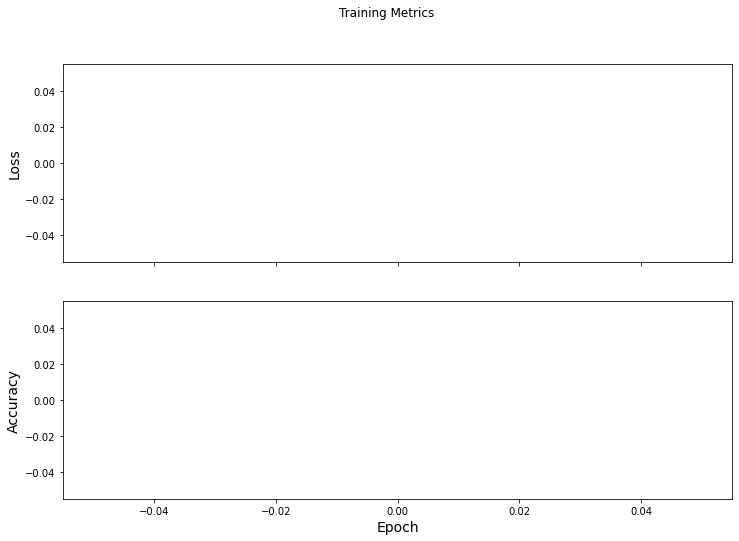

In [153]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [ ]:
test_accuracy = tf.keras.metrics.Accuracy()
ds_test_batch = ds_test.batch(10)

for (x, y) in ds_test_batch:
    # training=False is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    logits = model(x, training=False)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int64)
    test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))